In [1]:
import numpy as np

class FVec(np.ndarray): # function vector
    
    def __new__(cls, a):
        obj = np.asarray(a).view(cls)
        return obj
        
    def __call__(self, point):
        point = Vec(point)
        res = np.array(list(map(lambda f: f(point), self)))
        return res

class Vec(np.ndarray):
    
    def __new__(cls, a):
        obj = np.asarray(a).view(cls)
        return obj

    @property
    def x(self):
        return self[0]

    @property
    def y(self):
        return self[1]

    @property
    def z(self):
        return self[2]

class TimeRange:

    def __init__(self, bounds):

        self.start = bounds[0]
        self.end = bounds[1]

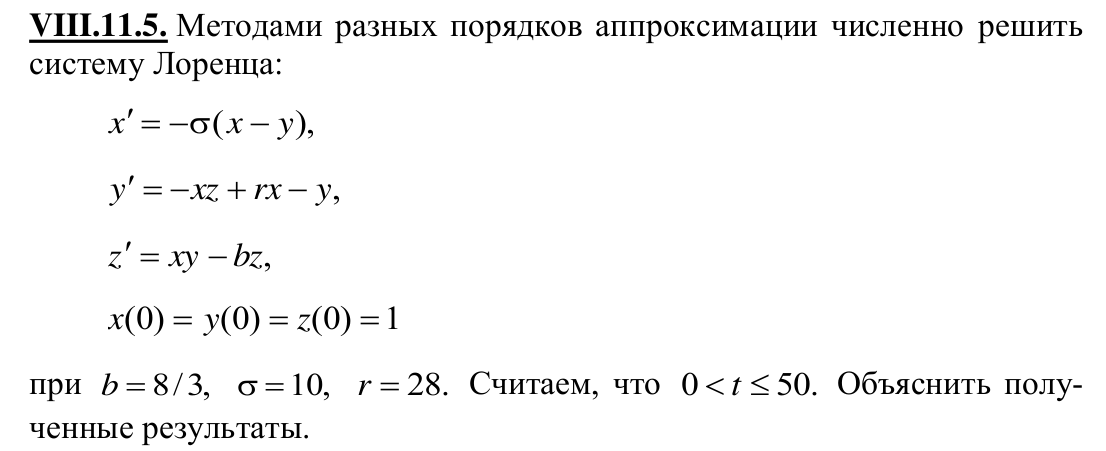

In [2]:
# Parameters
b = 8/3
sigma = 10.
r = 28.
time = TimeRange([0., 20.])
h_std = 0.01

# Initial values

x0 = 0.
y0 = 1.
z0 = 1.5

vec0 = Vec([x0, y0, z0])

fx = lambda point: sigma * (point.y - point.x)
fy = lambda point: point.x * (r - point.z) - point.y
fz = lambda point: point.x * point.y - b * point.z

fvec = FVec([fx, fy, fz])

In [3]:
def euler_step(fvec, vecs, i, h):

    vec = vecs[i-1]

    next_vec = vec + fvec(vec) * h
    
    return next_vec

def solveODE(fvec, vec0, time, h, main_step, warmup_num = 0, warmup_step = euler_step):

    N = int((time.end - time.start) / h)
    
    vecs = np.empty((N + 1, vec0.size))
    vecs[0] = vec0

    for i in range(1, warmup_num + 1):

        vecs[i] = warmup_step(fvec, vecs, i, h)

    for i in range(warmup_num + 1, N + 1):

        vecs[i] = main_step(fvec, vecs, i, h)    

    return vecs

def plotSolution(vecs):

    fig = plt.figure().add_subplot(projection = '3d')
    plt.plot(*vecs.T, lw = 0.5)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

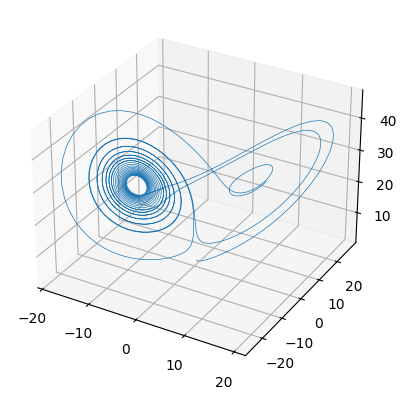

In [5]:
# RK4

# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

def rk4_step(fvec, vecs, i, h):

    vec = vecs[i-1]
    
    k1 = fvec(vec)
    k2 = fvec(vec + h/2 * k1)
    k3 = fvec(vec + h/2 * k2)
    k4 = fvec(vec + h * k3)

    next_vec = vec + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)

    return next_vec

vecs = solveODE(fvec, vec0, time, h_std, rk4_step)

plotSolution(vecs)

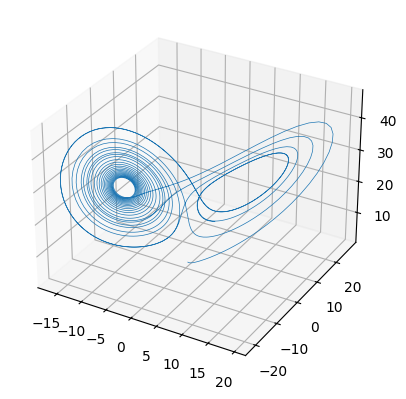

In [6]:
# Adams–Bashforth

# https://en.wikipedia.org/wiki/Linear_multistep_method

def multistep_warmup_check(i, steps_required):

    if i <= steps_required:

        raise IndexError(f'Method needs {steps_required} warmup steps')
    

def adams_step(fvec, vecs, i, h):

    multistep_warmup_check(i, steps_required = 4)
    
    next_vec = vecs[i-1] + h * (55/24 * fvec(vecs[i-1]) - 59/24 * fvec(vecs[i-2]) + 37/24 * fvec(vecs[i-3]) - 9/24 * fvec(vecs[i-4]))

    return next_vec

vecs = solveODE(fvec, vec0, time, h_std, main_step = adams_step, warmup_num = 4, warmup_step = rk4_step)

plotSolution(vecs)

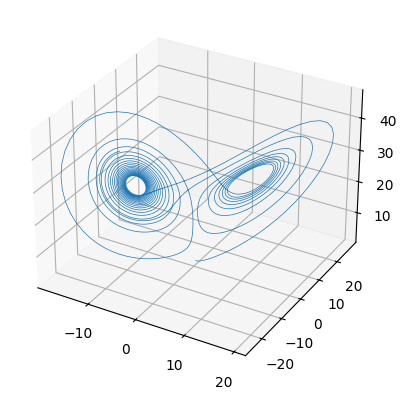

In [7]:
# Backward Differentiation

# https://en.wikipedia.org/wiki/Backward_differentiation_formula

from scipy import optimize

def BDF_step(fvec, vecs, i, h):

    multistep_warmup_check(i, steps_required = 4)
    
    tmp_c = (-48/25) * vecs[i-1] + (36/25) * vecs[i-2] + (-16/25) * vecs[i-3] + (3/25) * vecs[i-4]
    F = lambda point: point + tmp_c - (12/25) * h * fvec(point)

    F_as_fvec = FVec([lambda point, i=i: F(point)[i] for i in range(3)])
    
    sol = optimize.root(F_as_fvec, vecs[i-1])
    
    next_vec = Vec(sol.x)

    return next_vec

vecs = solveODE(fvec, vec0, time, h_std, BDF_step, warmup_num = 4, warmup_step = rk4_step)

plotSolution(vecs)

In [8]:
def plotSolution2D(vecs):

    x = vecs.T[0]
    y = vecs.T[1]
    z = vecs.T[2]
    plt.plot(x, y)

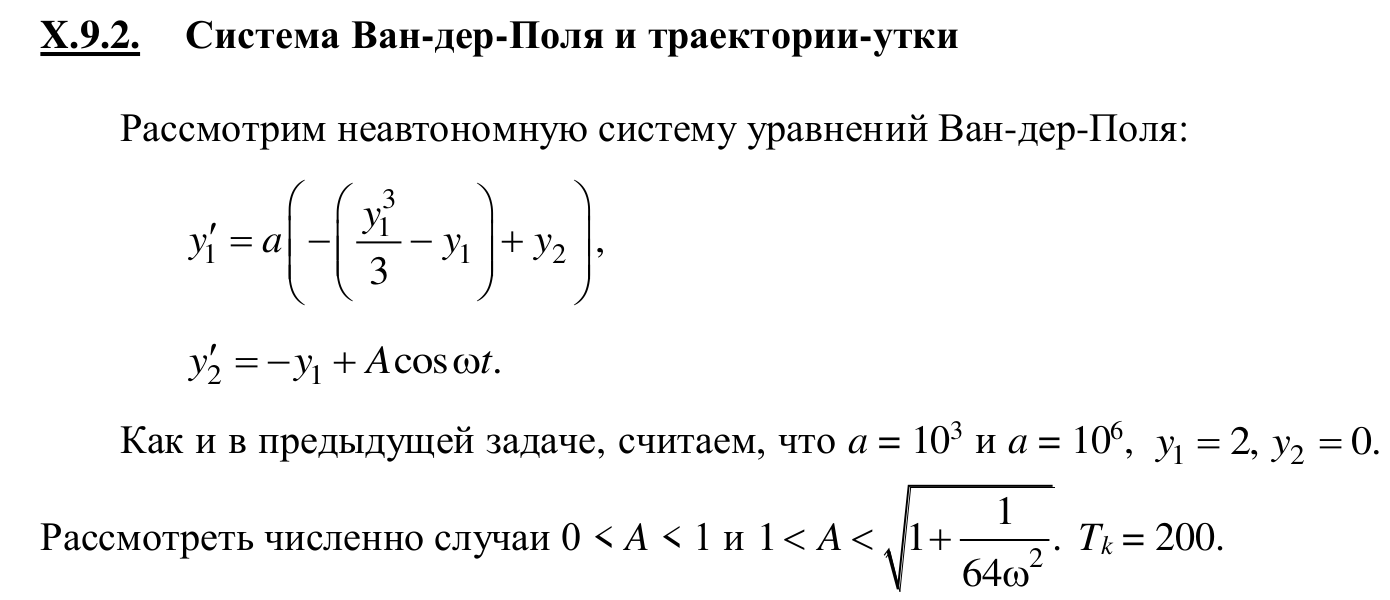

In [9]:
a = 10**3 # && 10**6
A = 1.0000008
w = 2 * np.pi / 20
time = TimeRange([0, 200])

f1 = lambda point: a * (point.y - ((point.x)**3/3 - point.x))
f2 = lambda point: -point.x + A * np.cos(w * point[2])
f3 = lambda point: 1

fvec = FVec([f1, f2, f3])

vec0 = Vec([2, 0, 0])

/tmp/ipykernel_23394/4101762770.py:6: RuntimeWarning: overflow encountered in double_scalars
  f1 = lambda point: a * (point.y - ((point.x)**3/3 - point.x))
/tmp/ipykernel_23394/4101762770.py:6: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda point: a * (point.y - ((point.x)**3/3 - point.x))


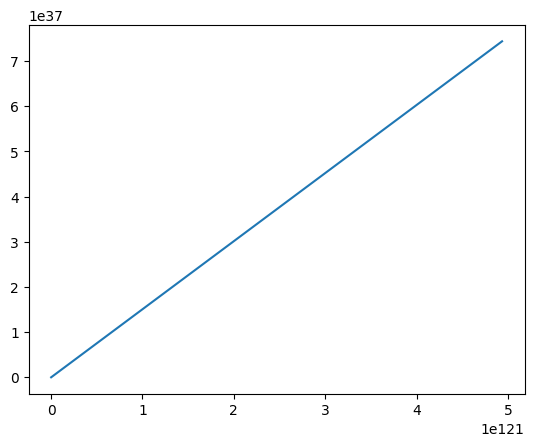

In [11]:
vecs = solveODE(fvec, vec0, time, h_std, main_step = rk4_step)
plotSolution2D(vecs)

Явный нестабилен. Поэтому мы видим, что решение уходит в бесконечность при применении к жёсткой системе.

# Implicit RK based on Gaussian quadrature

https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_method

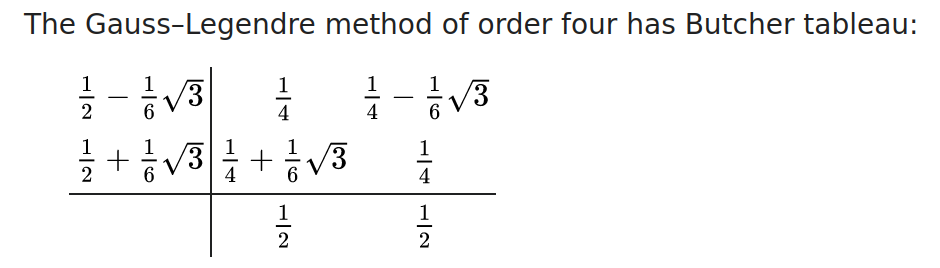

In [13]:
c = Vec([1/2 - 1/6 * 3**0.5, 1/2 + 1/6 * 3**0.5])

a00 = 1/4
a01 = 1/4 - 1/6 * 3**0.5
a10 = 1/4 + 1/6 * 3**0.5
a11 = 1/4

b = Vec([1/2, 1/2])

In [18]:
def IRK_step(fvec, vecs, i, h):

    prev_vec = vecs[i-1]
    
    tk0 = lambda k: fvec(prev_vec + h_std * (a00 * k[0:3] + a01 * k[3:6])) - k[0:3]
    tk1 = lambda k: fvec(prev_vec + h_std * (a10 * k[0:3] + a11 * k[3:6])) - k[3:6]

    tk_base = FVec([tk0, tk1])
    tk = FVec([lambda k, i=i, j=j: tk_base[i](k)[j] for i in range(2) for j in range(3)])
    tk_init = Vec([0, 0, 0, 0, 0, 0])
    
    sol = optimize.root(tk, tk_init)
    k = sol.x

    k1 = k[0:3]
    k2 = k[3:6]

    return prev_vec + h * (b[0] * k1 + b[1] * k2)

Неявный метод даже при таком же шаге (по сравнению с явным) сходится к решению - фигуре, которую называют "траектория-утка".

In [ ]:
Поварьируем ширину шага. Особенностью неявных методов 

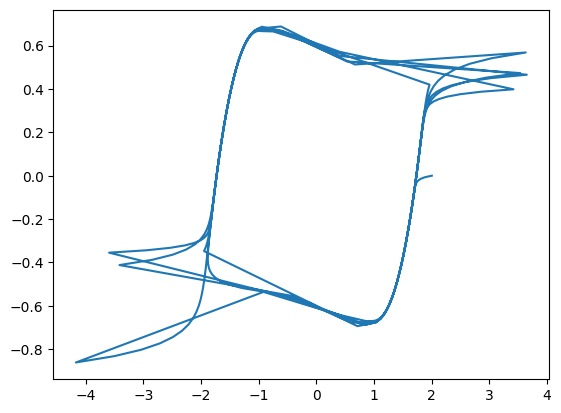

In [19]:
# Исходный шаг 0.01
vecs = solveODE(fvec, vec0,   TimeRange([0., 10.]), h_std, main_step = IRK_step)
plotSolution2D(vecs)

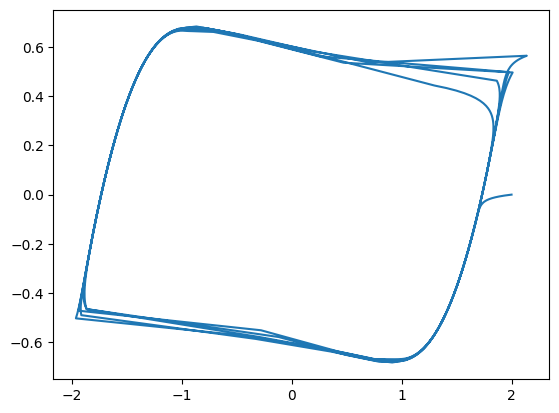

In [20]:
# в 2 раза меньше
vecs = solveODE(fvec, vec0,   TimeRange([0., 10.]), h_std / 2, main_step = IRK_step)
plotSolution2D(vecs)

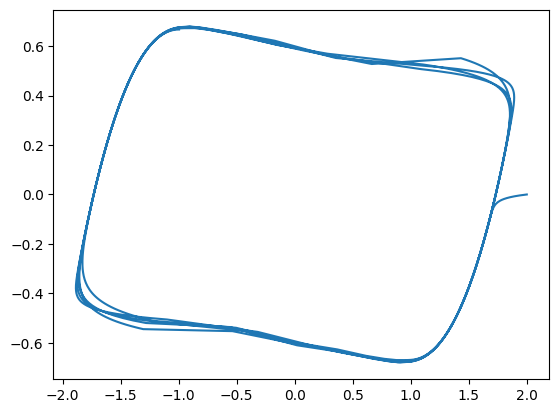

In [21]:
# в 4 раза меньше
vecs = solveODE(fvec, vec0,   TimeRange([0., 10.]), h_std / 4, main_step = IRK_step)
plotSolution2D(vecs)

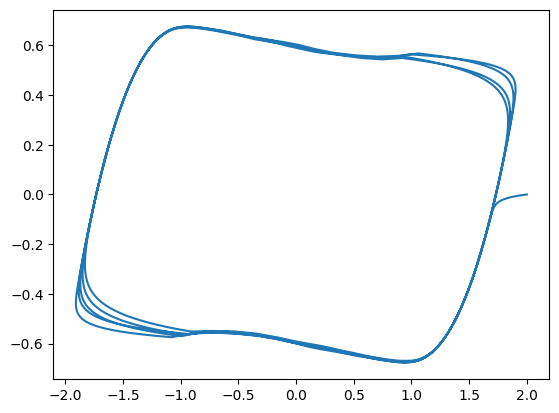

In [23]:
# в 16 раз меньше
vecs = solveODE(fvec, vec0,   TimeRange([0., 10.]), h_std / 16, main_step = IRK_step)
plotSolution2D(vecs)

Наблюдаем, что при уменьшении шага - метод начинает лучше сходится.